Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


Extracted the CNN_assigment folder and Uploaded it on the google drive in Colab Notebooks folder.

NT Comments: Added comments by Nilit Tinna 

### Importing all the important libraries

In [9]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from glob import glob

In [10]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [11]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset -- Done. 
# NT Comments: the mapped google drive name: /content/gdrive/MyDrive without the spaces
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [12]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [13]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [14]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
## NT Comments: Done; resized the images and defined the batch for training dataset
train_ds =  tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [15]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
## NT Comments: Done; resized the images and defined the batch for validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [16]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
# NT Comments: Done
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

### NT Comments: Below are the images one from each class in the training dataset

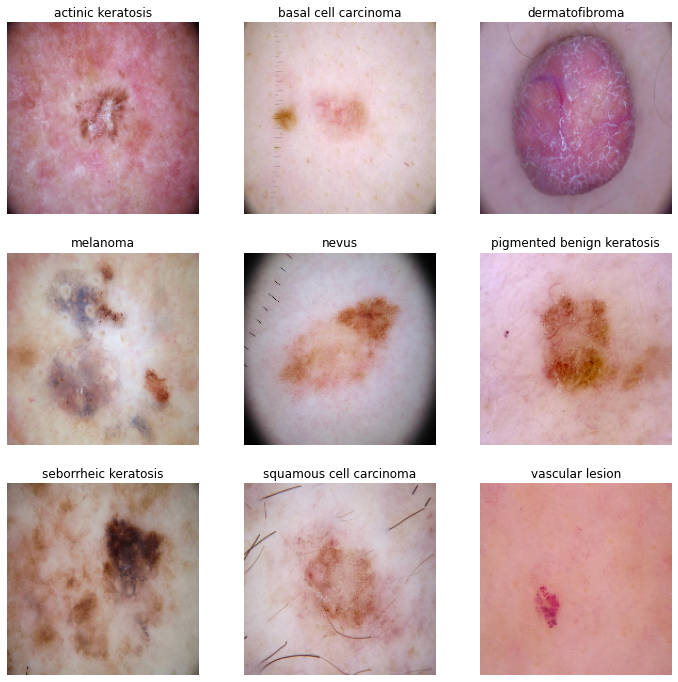

In [17]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(12, 12))

for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [19]:
#Number of Classes
num_class = 9
model1 = Sequential()
# Added rescaling to normalize pixel values
model1.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))

# Added 4 convolutions with pooling layers to reduce the size of the image and input shape
model1.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model1.add(MaxPooling2D(pool_size = (2, 2)))

model1.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model1.add(MaxPooling2D(pool_size = (2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

#flatten and put a fully connected layer
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(128, activation='relu'))
# softmax layer
model1.add(Dense(num_class, activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [20]:
### Todo, choose an appropirate optimiser and loss function
### NT Comments: Added adam optimizer and cross entropy loss function
model1.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [21]:
# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [22]:
#Train the base model for 20 epochs
epochs = 20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  workers = 10,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 71s 687ms/step - loss: 2.0271 - accuracy: 0.2148 - val_loss: 2.0192 - val_accuracy: 0.2013
Epoch 2/20
56/56 [==============================] - 2s 31ms/step - loss: 1.8942 - accuracy: 0.2997 - val_loss: 2.2081 - val_accuracy: 0.2931
Epoch 3/20
56/56 [==============================] - 2s 30ms/step - loss: 1.8065 - accuracy: 0.3337 - val_loss: 1.6506 - val_accuracy: 0.4139
Epoch 4/20
56/56 [==============================] - 2s 30ms/step - loss: 1.6741 - accuracy: 0.3850 - val_loss: 1.6855 - val_accuracy: 0.3602
Epoch 5/20
56/56 [==============================] - 2s 30ms/step - loss: 1.6174 - accuracy: 0.4319 - val_loss: 1.5487 - val_accuracy: 0.4653
Epoch 6/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4888 - accuracy: 0.4721 - val_loss: 1.4321 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4013 - accuracy: 0.5039 - val_loss: 1.4956 - val_accuracy: 0.4765
Epoch 8/20


### Visualizing training results

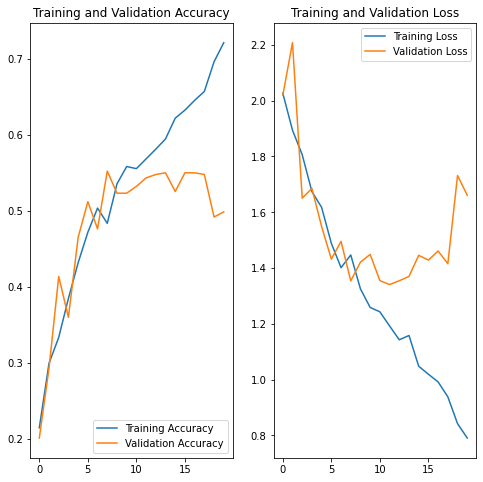

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The above plots shows huge difference in training and validation accuracy. Since validation accuracy drops significantly and validation loss increases, overfitting is observed. We will use augmentation strategy to flip, rotate and zoom images to improve the accuracy and decrease the loss.



### Write your findings here

In [24]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Data augumentation strategy. 
# NT Comments: Using RandomFlip, Rotation and Zoom for data augmentation
data_augmentation = keras.Sequential([
                                      layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                      layers.experimental.preprocessing.RandomRotation(0.2),
                                      layers.experimental.preprocessing.RandomZoom(0.2),
])

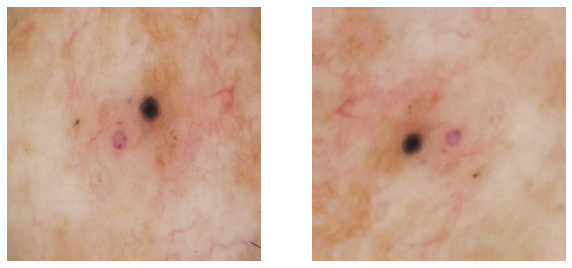

In [25]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# NT Comments: Flipped Image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    ax = plt.subplot(1, 2, 1)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")
    augmented_images = data_augmentation(images)
    ax = plt.subplot(1, 2, 2)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.show()

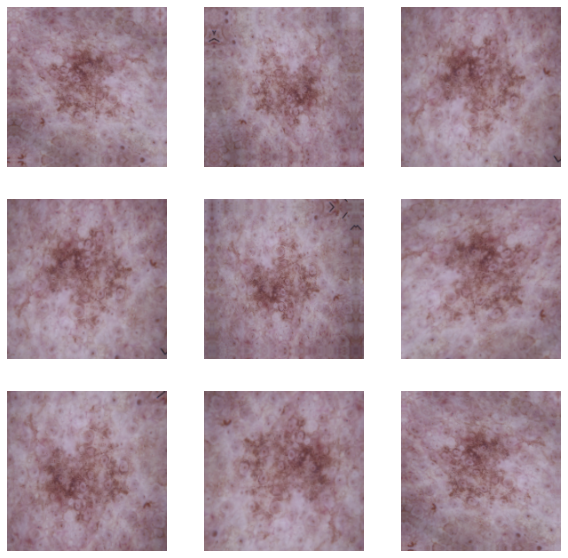

In [26]:
# visualize augmentation strategy works for one instance of training image.
# NT Comments: Rotated Images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [27]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
# NT Comments: Using Dropout Layer; num_cat is number of classes = 9
num_cat = 9
model2 = Sequential([ data_augmentation,
                   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model2.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model2.add(MaxPooling2D(pool_size = (2, 2)))

model2.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model2.add(MaxPooling2D(pool_size = (2, 2)))


model2.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

#flatten and put a fully connected layer
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
# softmax layer
model2.add(Dense(num_cat, activation='softmax'))



### Compiling the model

In [28]:
## NT Comments: Compiling the model. Using adam and SparseCategoricalCrossentropy as mentioned earlier
model2.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [29]:
## Your code goes here, note: train your model for 20 epochs
## NT Comments: Training the model with 20 epochs
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  workers=10,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 37ms/step - loss: 2.0691 - accuracy: 0.1920 - val_loss: 2.0378 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 2s 34ms/step - loss: 1.9813 - accuracy: 0.2344 - val_loss: 1.8598 - val_accuracy: 0.3490
Epoch 3/20
56/56 [==============================] - 2s 34ms/step - loss: 1.8077 - accuracy: 0.3298 - val_loss: 1.6371 - val_accuracy: 0.4340
Epoch 4/20
56/56 [==============================] - 2s 34ms/step - loss: 1.6502 - accuracy: 0.3990 - val_loss: 1.5244 - val_accuracy: 0.4362
Epoch 5/20
56/56 [==============================] - 2s 34ms/step - loss: 1.5370 - accuracy: 0.4554 - val_loss: 1.4605 - val_accuracy: 0.4855
Epoch 6/20
56/56 [==============================] - 2s 33ms/step - loss: 1.5203 - accuracy: 0.4509 - val_loss: 1.4623 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 2s 34ms/step - loss: 1.4416 - accuracy: 0.4760 - val_loss: 1.4385 - val_accuracy: 0.5056
Epoch 8/20
56

### Visualizing the results

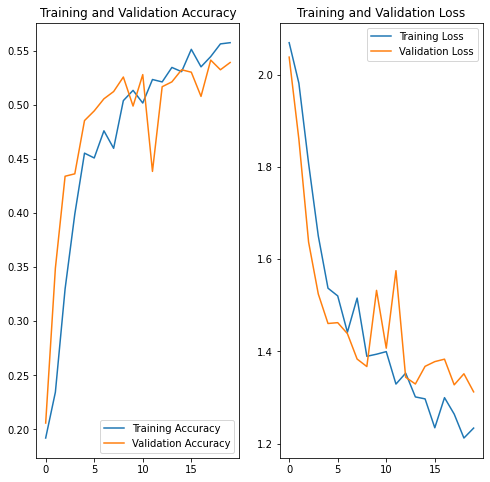

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

From the above plots, there is definitely an improvement over the base model as the accuracy has improved and the difference between the training and validation accuracy has reduced significantly. There is a considerable decrease in the training and validation loss as compared to the base model, however the difference between training and validation loss eludes to some overfitting.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [31]:
## Get the list of classes and put them in a dataframe
df_cancertypes=[]
for classtype in class_names:
  class_list = [x for x in data_dir_train.glob(classtype+'/*.jpg')]
  df_cancertypes.append(len(class_list))
df_cancertypes = pd.DataFrame(list(zip(class_names,df_cancertypes)),columns=["Category","Count"])
print(df_cancertypes)

                     Category  Count
0           actinic keratosis    114
1        basal cell carcinoma    376
2              dermatofibroma     95
3                    melanoma    438
4                       nevus    357
5  pigmented benign keratosis    462
6        seborrheic keratosis     77
7     squamous cell carcinoma    181
8             vascular lesion    139


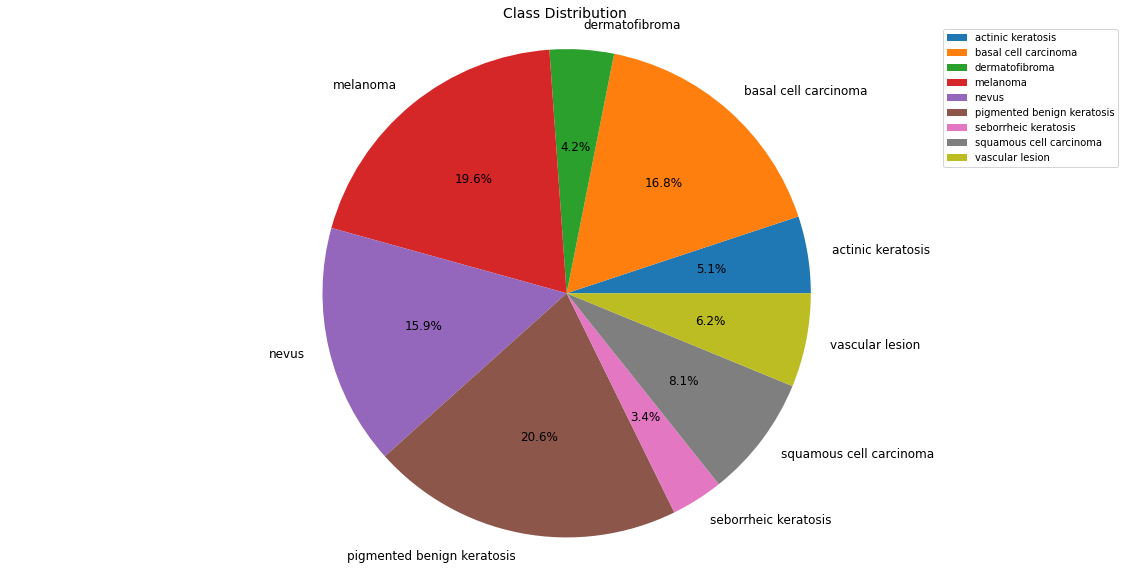

In [32]:
#Pie chart to review the class distribution
ax = (df_cancertypes["Count"]*100.0 /sum(df_cancertypes["Count"])).plot.pie(autopct='%.1f%%', labels = df_cancertypes["Category"],figsize =(20,10), fontsize = 12)                                                                           
ax.set_ylabel('',fontsize = 12)
ax.set_title('Class Distribution', fontsize = 14)
plt.legend(df_cancertypes["Category"])
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

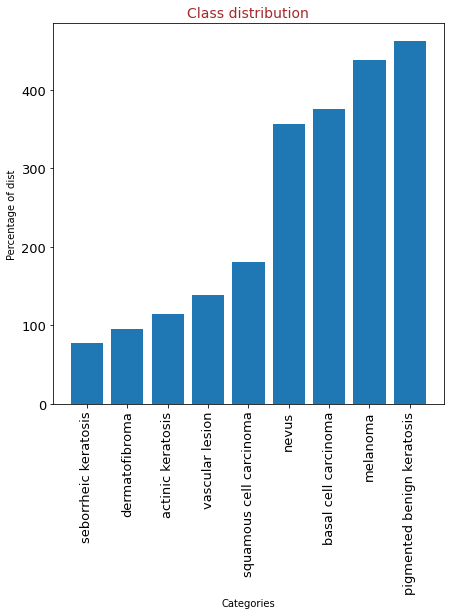

In [33]:
#Bar chart to review the classes
df_cancertypes.sort_values(by="Count",inplace=True)
plt.figure(figsize=(7,7))
plt.bar(x=df_cancertypes["Category"],height=df_cancertypes["Count"])
plt.yticks(fontsize=13)
plt.xlabel('Categories')
plt.ylabel('Percentage of dist')
plt.title('Class distribution',fontdict={'fontsize': 14, 'fontweight' : 5, 'color' : 'Brown'})
plt.xticks(fontsize = 13,rotation=90)
plt.show()

In [34]:
path_list = [x for x in data_dir_train.glob(os.path.join( '*', '*.jpg'))]
print("path_list: ",len(path_list))
lesion_list = [os.path.basename(os.path.dirname(y)) for y in data_dir_train.glob(os.path.join( '*', '*.jpg'))]
print("lesion_list: ",len(lesion_list))
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
print(original_df.Label.value_counts())
original_df.head()

path_list:  2239
lesion_list:  2239
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64


,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/CNN_as...,actinic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/CNN_as...,actinic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/CNN_as...,actinic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/CNN_as...,actinic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/CNN_as...,actinic keratosis


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? 
### NT Comments: seborrheic keratosis has least samples i.e. 77
#### - Which classes dominate the data in terms proportionate number of samples?
### NT Comments: pigmented benign keratosis(462), melanoma                      (438), basal cell carcinoma(376), nevus(357) dominates the dataset with around 73% of sample. This is clear case of class imbalance. We will use augmentor to improve rectify the class imbalance.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [35]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [36]:
path_to_training_dataset= "/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F70DED55590>: 100%|██████████| 500/500 [00:22<00:00, 22.06 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F70DECAAF90>: 100%|██████████| 500/500 [00:21<00:00, 23.46 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F70DED474D0>: 100%|██████████| 500/500 [00:22<00:00, 22.26 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F70DEC1BC50>: 100%|██████████| 500/500 [01:40<00:00,  4.97 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1011x713 at 0x7F70DED16150>: 100%|██████████| 500/500 [01:19<00:00,  6.29 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F70DEC70850>: 100%|██████████| 500/500 [00:24<00:00, 20.81 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F70DECDE450>: 100%|██████████| 500/500 [00:45<00:00, 10.95 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F70DEC70AD0>: 100%|██████████| 500/500 [00:17<00:00, 27.86 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F70E12C4290>: 100%|██████████| 500/500 [00:18<00:00, 27.35 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new = path_list


In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [40]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [42]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [44]:
data_dir_train="/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [45]:
#Creating the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [46]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization -- Batch normalization is added in Model 4 below)

In [47]:
## Creating model 3 with augmented data and class imbalance rectification
num_classes = 9
model3 = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model3.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model3.add(MaxPooling2D(pool_size = (2, 2)))

model3.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model3.add(MaxPooling2D(pool_size = (2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))
#flatten and put a fully connected layer
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(128, activation='relu'))
# softmax layer
model3.add(Dense(num_classes, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [48]:
## Compiling model with Adam optimizer and cross entropy loss function
model3.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [49]:
## Training model with 30 epochs
epochs = 30
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 33s 66ms/step - loss: 2.1792 - accuracy: 0.1402 - val_loss: 2.1067 - val_accuracy: 0.1359
Epoch 2/30
169/169 [==============================] - 5s 31ms/step - loss: 1.8916 - accuracy: 0.2671 - val_loss: 1.7216 - val_accuracy: 0.3556
Epoch 3/30
169/169 [==============================] - 5s 31ms/step - loss: 1.5603 - accuracy: 0.3887 - val_loss: 1.4849 - val_accuracy: 0.4543
Epoch 4/30
169/169 [==============================] - 5s 32ms/step - loss: 1.4304 - accuracy: 0.4362 - val_loss: 1.3787 - val_accuracy: 0.4692
Epoch 5/30
169/169 [==============================] - 5s 31ms/step - loss: 1.3685 - accuracy: 0.4685 - val_loss: 1.2917 - val_accuracy: 0.4989
Epoch 6/30
169/169 [==============================] - 5s 31ms/step - loss: 1.2385 - accuracy: 0.5213 - val_loss: 1.1716 - val_accuracy: 0.5642
Epoch 7/30
169/169 [==============================] - 5s 32ms/step - loss: 1.0908 - accuracy: 0.5861 - val_loss: 1.1411 - val_accuracy: 0.570

#### **Todo:**  Visualize the model results

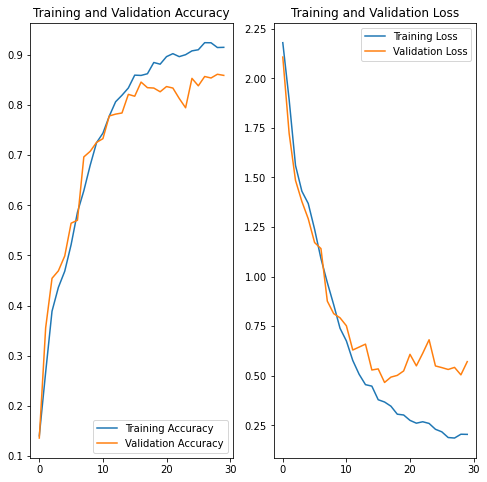

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
### NT Comments: Some improvement is observed in this model as compared to model2. However, the difference between the training and validation accuracy & loss have both increased which is pointing to overfitting.

Model4 : Model with Rebalanced data , Dropouts and BatchNormalization

In [51]:
#Batch Normalization


num_classes = 9
model4 = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model4.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model4.add(MaxPooling2D(pool_size = (2, 2)))
model4.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model4.add(MaxPooling2D(pool_size = (2, 2)))

model4.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.2))
model4.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))

#flatten and put a fully connected layer
model4.add(Dropout(0.2))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dense(128, activation='relu'))
# softmax layer
model4.add(Dense(num_classes, activation='softmax'))

In [53]:
# Compile the model
model4.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [54]:
#Train the model
epochs = 30
## Your code goes here, use 30 epochs.
history = model4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 6s 34ms/step - loss: 1.6023 - accuracy: 0.4026 - val_loss: 2.7675 - val_accuracy: 0.2019
Epoch 2/30
169/169 [==============================] - 5s 31ms/step - loss: 1.2825 - accuracy: 0.5096 - val_loss: 3.7972 - val_accuracy: 0.1581
Epoch 3/30
169/169 [==============================] - 5s 31ms/step - loss: 1.0731 - accuracy: 0.5942 - val_loss: 1.4032 - val_accuracy: 0.4885
Epoch 4/30
169/169 [==============================] - 5s 31ms/step - loss: 0.8530 - accuracy: 0.6849 - val_loss: 1.5652 - val_accuracy: 0.5093
Epoch 5/30
169/169 [==============================] - 5s 31ms/step - loss: 0.7372 - accuracy: 0.7246 - val_loss: 1.5775 - val_accuracy: 0.4759
Epoch 6/30
169/169 [==============================] - 5s 32ms/step - loss: 0.5938 - accuracy: 0.7721 - val_loss: 1.6647 - val_accuracy: 0.5204
Epoch 7/30
169/169 [==============================] - 5s 31ms/step - loss: 0.5000 - accuracy: 0.8095 - val_loss: 1.4214 - val_accuracy: 0.5687

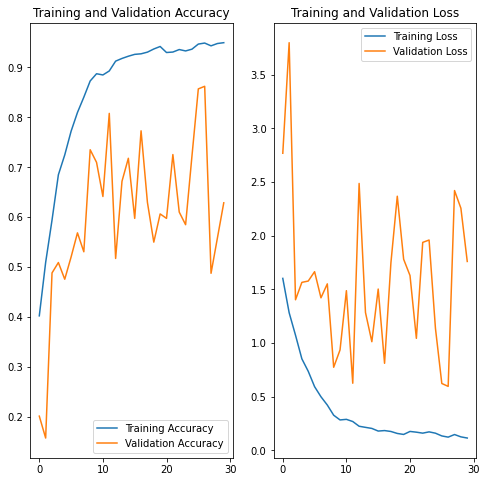

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



NT Comments: Considering the huge spikes in Model4, this does not look like a good consistent model

Model 1 
Base Model
Accuracy: Train = 76% and Validation = 51% 

Model 2 
With Dropouts and Data Augmentation
Accuracy: Train = 54% and Validation = 51%

Model 3
With Augementated data and aclass imbalance rectification
Accuracy: Train = 89% and Validation = 81% 

Model 4 
with Rebalanced data , Dropouts and BatchNormalization
Accuracy: Train = 95% and Validation = 82%


Looking at the model performance(including loss), Model 3 looks like a reasonably consistent model and hence using it to run over the testing data.

In [56]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [57]:
#Just for rescaling the test image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_generator  = ImageDataGenerator(rescale=1./255)                                    # no aug for test
test_generator  = test_generator.flow_from_directory(data_dir_test,
                                                     target_size=(img_height, img_width),
                                                     batch_size = batch_size,                                                                 
                                                     )                
                                                     

Found 118 images belonging to 9 classes.


In [58]:
#Predicting the probabilities for all the test data
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model3.predict(test_images_ds)
classes_x=np.argmax(probabilities,axis=1)

In [59]:
class_labels=[]
for i in classes_x:
  class_labels.append(class_names[i])

In [60]:
#Check the probability of the class for first image
score = tf.nn.softmax(probabilities[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to basal cell carcinoma with a 25.21 percent confidence.


In [61]:
probabilities.shape

(118, 9)

In [62]:
# probabilities for each class for first test image
probabilities[0,:]

array([2.6857228e-06, 9.9292952e-01, 4.1855685e-07, 2.8386086e-07,
       1.0773902e-06, 1.3334128e-05, 9.4104449e-09, 7.0526036e-03,
       2.5481084e-09], dtype=float32)

In [63]:
file_paths = test_ds.file_paths

In [64]:
#Code to retrieve the image names from filepaths and add them in a list
img_count_test  = len(list(data_dir_test.glob('*/*.jpg')))
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(img_count_test))).numpy().astype('U')

img_list = []
img_id_list = []
img_name_list = []
for i in range(len(file_paths)):
    img_list.append(file_paths[i].split(os.sep)[-1])
    img_id_list.append(i)
    img_name_list.append(file_paths[i].split(os.sep)[-1][0:-4])

img_name_list_by_test_ids = []
for iid in list(test_ids):
    img_name_list_by_test_ids.append(img_name_list[int(iid)])

In [65]:
#Put the image name and class lable in a dataframe
pred_df = pd.DataFrame({'image_name': img_name_list, 'predicted': class_labels})
pred_df

,image_name,predicted
0,ISIC_0024511,basal cell carcinoma
1,ISIC_0024408,basal cell carcinoma
2,ISIC_0000035,basal cell carcinoma
3,ISIC_0024358,pigmented benign keratosis
4,ISIC_0024454,actinic keratosis
...,...,...
113,ISIC_0011751,basal cell carcinoma
114,ISIC_0010809,squamous cell carcinoma
115,ISIC_0024412,squamous cell carcinoma
116,ISIC_0000003,nevus
